<a href="https://colab.research.google.com/github/HedersonSantos/Noticias/blob/main/clusterizacaoNoticias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords



from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering

# Obtendo dataset de noticias tratadas em preProcessamento_noticias

In [3]:
!rm news.*
!wget https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
!unzip news.zip
%ls

rm: cannot remove 'news.*': No such file or directory
--2021-06-19 15:38:59--  https://raw.githubusercontent.com/HedersonSantos/Noticias/main/news.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11333903 (11M) [application/zip]
Saving to: ‘news.zip’

news.zip            100%[===================>]  10.81M  53.0MB/s    in 0.2s    

2021-06-19 15:39:00 (53.0 MB/s) - ‘news.zip’ saved [11333903/11333903]

Archive:  news.zip
  inflating: news.csv                
news.csv  news.zip  sample_data/


# Funções para processamento de Linguagem Natural

In [9]:
def download_pt_stopWords():

  '''download das stopwords '''
  nltk.download('stopwords') #stopwords
  nltk.download('rslp')  #stemming
        
def removeStopWords( texto, excluirWords:list=None):
  '''remove as stopwords do texto. Novas stopwords podem ser adicionadas através da lista excluirWords'''
  naoQueridas = nltk.corpus.stopwords.words('portuguese')
  if not excluirWords==None:
    naoQueridas.extend(excluirWords)
  naoQueridas = list(set(naoQueridas))
  palavras = [i for i in texto.split() if not i.lower() in naoQueridas]
  return (" ".join(palavras))

def aplicaStemming( texto):
  ''' obtém o radical das palavras do vocabulário'''
  stemmer = nltk.stem.RSLPStemmer()
  palavras = []
  for w in texto.split():
      palavras.append(stemmer.stem(w))
  return (" ".join(palavras))

def removeCaracteresNaoDesejados(texto):
  textoLimpo = re.sub(r"http\S+", "", texto)
  textoLimpo = re.sub(r"www\..+\..+", "", texto)
  textoLimpo = re.sub(r"[^a-zA-ZáÁéÉíÍóÓúÚãÃàÀôâÂêÊôÔçÇ!,:.; ]", "", texto)
  return textoLimpo

def retornaVetorizacao(X,pct_min=1, pct_max=1, excluirSW:list=None):
  ''' monta a matriz sparsa com o índice de vocabulário em cada texto. 
    Retorna a matriz sparsa e o vocabulário '''
  count_vect = CountVectorizer(min_df=pct_min, max_df=pct_max, lowercase=True,stop_words=excluirSW) 
  matriz_sparsa = count_vect.fit_transform(X)
  vocabulario = count_vect.fit(X)
  return [matriz_sparsa,count_vect]

def retornaMatriztfIdf( V):
    ''' em cada documento, calcula o tf-idf de cada palavra
        term frequency - inverse document frequency'''
    tfidf_transformer = TfidfTransformer()
    matriz_tfidf = tfidf_transformer.fit_transform(V)
    return matriz_tfidf

def normalizaEreduzDimensionalidadecomPCA( X, nro_dimensao,UT=None):
    X_norm = StandardScaler(with_mean=False).fit_transform(X)
    data_pca= TruncatedSVD(nro_dimensao)
    if UT==None:
        UT = data_pca.fit(X_norm)
    X_pca =  UT.fit_transform(X_norm)
      
    return [UT,X_pca]

# Prepara dataset para clusterizacao

In [5]:
#abrir arquivo news.csv
dfDados = pd.read_csv('news.csv')
dfDados['TEXT_TRATADO'] = dfDados['TEXT_TRATADO'].astype('unicode')
dfDados['TEXT_TRATADO'] = dfDados.loc[:,['TEXT_TRATADO']].apply(lambda x: removeCaracteresNaoDesejados(x['TEXT_TRATADO']),axis=1)
download_pt_stopWords()
dfDados['TEXT_TRATADO'] = dfDados.loc[:,['TEXT_TRATADO']].apply(lambda x: removeStopWords(x['TEXT_TRATADO']),axis=1)
dfDados['TEXT_TRATADO'] = dfDados.loc[:,['TEXT_TRATADO']].apply(lambda x: aplicaStemming(x['TEXT_TRATADO']),axis=1)
dfDados[['TEXT_TRATADO']].head(3)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


,TEXT_TRATADO
0,sext bbb tv glob broth receb com beb faz aquec...
1,"program viv bbb tv globo, leifert convers empa..."
2,"continu dizendo, deu tir daquel cadeira. vai s..."


In [12]:
X = dfDados['TEXT_TRATADO'].values
min_fr=0.01; max_fr=0.7
vetores = retornaVetorizacao(X,min_fr,max_fr) 
V = vetores[0]
X_tfidf = retornaMatriztfIdf(V)


<1x3352 sparse matrix of type '<class 'numpy.float64'>'
	with 171 stored elements in Compressed Sparse Row format>

In [22]:
model = AgglomerativeClustering(distance_threshold=10, n_clusters=None)
model = model.fit(X_tfidf.toarray())

In [23]:
print('nro cluster:',model.n_clusters_)
distancia = model.distances_
print('distância minima:', distancia.min(), '\n distância máxima:', distancia.max())

nro cluster: 5
distância minima: 0.0 
 distância máxima: 14.32355324054458


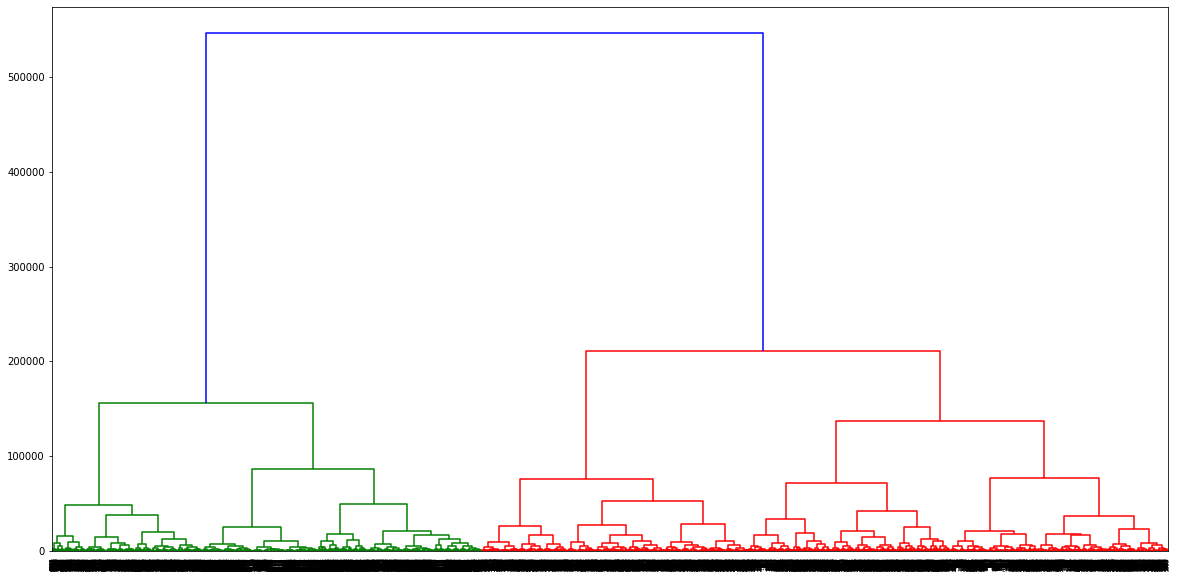

In [24]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
Z = hierarchy.linkage(model.children_, 'ward')
plt.figure(figsize=(20,10))
dn = hierarchy.dendrogram(Z)